In [1]:
# First, load the reticulate library and import the sagemaker Python module
library(reticulate)
sagemaker  <- import('sagemaker')

In [2]:
# Create an Amazon Simple Storage Service (S3) bucket for your data
# Note - The default_bucket function creates a unique Amazon S3 bucket with the following name: "sagemaker-<aws-region-name>-<aws account number>"
session <- sagemaker$Session()
bucket <- session$default_bucket()

In [3]:
# Specify the IAM role’s ARN to allow Amazon SageMaker to access the Amazon S3 bucket. You can use the same IAM role used to create this Notebook:
role_arn <- sagemaker$get_execution_role()

In [4]:
# loading required packages (since these are already available on sagemaker R kernel, no need to install them)
library(tidyverse)
library(modelr)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [5]:
# loading airly sensor (sensor ids = 7201, 7599, 7803; instal ids = 41414, 41816, 42022) data for the period 15-08-2021 to 22-11-2021 (Only NO2, T and RH signals)
data_file <- 'data_airly.csv'
data_airly_all <- read_csv(file=data_file)#, col_types = cols("d", "d", "T", "c", "d", "d", "d"))
head(data_airly_all)

New names:
* `` -> ...1

Rows: 342156 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): status
dbl  (5): ...1, id, humidity, no2, temperature
dttm (1): date


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



...1,id,date,status,humidity,no2,temperature
<dbl>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>
0,42022,2021-08-15 00:00:00,RAW,71.82511,297.1198,24.94795
1,42022,2021-08-15 00:05:00,RAW,72.20479,297.1906,24.84013
2,42022,2021-08-15 00:10:00,RAW,72.43551,297.3429,24.74854
3,42022,2021-08-15 00:15:00,RAW,72.64743,297.4239,24.66797
4,42022,2021-08-15 00:20:00,RAW,72.76068,297.6219,24.64623
5,42022,2021-08-15 00:25:00,RAW,73.05018,297.7695,24.57725


In [6]:
tail(data_airly_all)

...1,id,date,status,humidity,no2,temperature
<dbl>,<dbl>,<dttm>,<chr>,<dbl>,<dbl>,<dbl>
342150,41414,2021-11-21 23:35:00,FINAL,92.5,38.87538,5.055697
342151,41414,2021-11-21 23:40:00,FINAL,92.5,38.27329,5.057915
342152,41414,2021-11-21 23:45:00,FINAL,92.5,37.88230,5.038173
342153,41414,2021-11-21 23:50:00,FINAL,92.5,37.67418,5.020109
342154,41414,2021-11-21 23:55:00,FINAL,92.5,38.57907,4.988378
342155,41414,2021-11-22 00:00:00,FINAL,NA,NA,NA


In [7]:
# loading coloated reference senso (balcony analyser T200) data for the same period
data_file <- 'data_ref-GMT.csv'
data_ref_all <- read_csv(file=data_file) %>%
      mutate(date = Time - lubridate::hours(1)) %>%  #convert tz gmt (utc+1) to utc
    select(-Time)
head(data_ref_all)

Rows: 28512 Columns: 4

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl  (3): NO, NO2, NOX
dttm (1): Time


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



NO,NO2,NOX,date
<dbl>,<dbl>,<dbl>,<dttm>
4.43,21.3,25.8,2021-08-15 00:00:00
3.14,20.8,24.0,2021-08-15 00:05:00
2.85,20.6,23.4,2021-08-15 00:10:00
3.60,20.8,24.4,2021-08-15 00:15:00
4.04,21.2,25.2,2021-08-15 00:20:00
4.53,22.0,26.5,2021-08-15 00:25:00


In [8]:
tail(data_ref_all)

NO,NO2,NOX,date
<dbl>,<dbl>,<dbl>,<dttm>
1.61,13.0,14.7,2021-11-21 22:30:00
1.69,13.8,15.5,2021-11-21 22:35:00
1.55,13.7,15.3,2021-11-21 22:40:00
1.45,13.3,14.7,2021-11-21 22:45:00
1.39,12.9,14.3,2021-11-21 22:50:00
1.44,13.2,14.6,2021-11-21 22:55:00


In [9]:
data_airly_nested <- data_airly_all %>% 
  group_by(id) %>% 
  nest()

In [10]:
f_data_id <- function(df) {
    df %>% 
    select(date, status, no2) %>% 
    pivot_wider(names_from = status, values_from = c(no2))
}
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id = map(data, f_data_id))

In [11]:
f_data_id_TRH <- function(df) {
    df %>% 
    filter(status=="RAW") %>% 
    select(date, temperature, humidity)
}
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id_TRH = map(data, f_data_id_TRH))

In [16]:
# loading required packages (since these are NOT already available on sagemaker R kernel, we need to install them first)
install.packages("openair")

also installing the dependencies ‘jpeg’, ‘latticeExtra’, ‘mapproj’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
f_base <- function(df) {
    df %>% 
    openair::timeAverage(avg.time = "60 min", statistic = "min", start.date = "2021-08-15 00:00:00")
}
# find baseline points (taking minimum of RAW over 1hr intervals)
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id_base = map(data_id, f_base))

In [18]:
f_TRH_mean <- function(df) {
    df %>% 
    openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")
}
# find temperature points corresponding to baseline values (averaging over the same 1hr period)
data_airly_nested <- data_airly_nested %>% 
    mutate(data_id_TRH_mean = map(data_id_TRH, f_TRH_mean))

In [19]:
f_base_train <- function(df1, df2) {
    cbind(df1[,1:3], df2[,2:3])
}
data_airly_nested <- data_airly_nested %>% 
    mutate(base_train = map2(data_id_base, data_id_TRH_mean, f_base_train))

In [20]:
# building a polynomial model on baseline vs T
f_model_poly <- function(df){
  lm(RAW ~ poly(temperature, 2), data=df %>% na.exclude())
}
data_airly_nested <- data_airly_nested %>% 
  mutate(model_poly = map(base_train, f_model_poly))

In [21]:
f_comb <- function(df1, df2) {
    inner_join(df1, df2, by=c("date"="date"))
}
data_airly_nested <- data_airly_nested %>% 
  mutate(data_id_comb = map2(data_id, data_id_TRH, f_comb))

In [22]:
# add predictions of the model to the train data to find new baseline values 
f_add_preds <- function(df, model) {
    add_predictions(df, model, var = "baseline")
}
data_airly_nested <- data_airly_nested %>% 
  mutate(data_id_comb = map2(data_id_comb, model_poly, f_add_preds))

In [23]:
data_airly_unnested  <- data_airly_nested %>% 
  select(id, data_id_comb) %>% 
  unnest(cols = c(data_id_comb))
head(data_airly_unnested)

id,date,RAW,AUX,PPB,FINAL,temperature,humidity,baseline
<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42022,2021-08-15 00:00:00,297.1198,291.0501,26.00640,47.91067,24.94795,71.82511,292.7546
42022,2021-08-15 00:05:00,297.1906,290.9707,26.64045,49.09779,24.84013,72.20479,292.7909
42022,2021-08-15 00:10:00,297.3429,290.9539,27.30686,50.34218,24.74854,72.43551,292.8216
42022,2021-08-15 00:15:00,297.4239,290.9917,27.46796,50.65224,24.66797,72.64743,292.8484
42022,2021-08-15 00:20:00,297.6219,291.0800,27.83964,51.33843,24.64623,72.76068,292.8556
42022,2021-08-15 00:25:00,297.7695,291.0375,28.59472,52.74053,24.57725,73.05018,292.8785


In [24]:
data_airly_unnested$date[nrow(data_airly_unnested)] - data_airly_unnested$date[1]

Time difference of 99 days

In [25]:
# split data into training; first 30 days (~30%), the rest for test (~70%)
data_airly_train <- data_airly_unnested %>%
  filter(date < "2021-09-15 00-00-00")

data_airly_test <- data_airly_unnested %>%
  filter(date >= "2021-09-15 00-00-00")

data_ref_train <- data_ref_all %>%
  filter(date < "2021-09-15 00-00-00")

data_ref_test <- data_ref_all %>%
  filter(date >= "2021-09-15 00-00-00")

In [26]:
# average data over 1hr to reduce data points for final modeling and to match reference station interval
f_mean <- function(df) {
  df %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")
}
data_airly_train_nested <- data_airly_train %>% 
  nest() %>% 
  mutate(data_mean = map(data, f_mean))

data_ref_train_1hr <- data_ref_train %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")

In [27]:
f_comb2 <- function(df) {
  inner_join(df, data_ref_train_1hr, by=c("date"="date"))
}
data_airly_train_nested <- data_airly_train_nested %>% 
  mutate(data_comb = map(data_mean, f_comb2))

In [28]:
# rebuild train dataset by combining airly and ref values
gas_train <- data_airly_train_nested %>% 
    unnest(data_comb) %>% 
    select(id, NO2, RAW, baseline, temperature) %>%
    na.exclude()

In [29]:
head(gas_train)

id,NO2,RAW,baseline,temperature
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42022,21.55833,297.4983,292.8679,24.60835
42022,17.80000,296.7222,293.0888,23.92445
42022,15.29167,296.2973,293.2589,23.37839
42022,11.87417,295.6056,293.4264,22.81762
42022,10.91667,295.7697,293.3731,22.99725
42022,13.33333,295.5761,292.9524,24.34073


In [32]:
# average data over 1hr to reduce data points to match train set processing
data_airly_test_nested <- data_airly_test %>% 
  nest() %>% 
  mutate(data_mean = map(data, f_mean))

data_ref_test_1hr <- data_ref_test %>% 
  openair::timeAverage(avg.time = "60 min", statistic = "mean", start.date = "2021-08-15 00:00:00")

In [33]:
f_comb3 <- function(df) {
  inner_join(df, data_ref_test_1hr, by=c("date"="date"))
}
data_airly_test_nested <- data_airly_test_nested %>% 
  mutate(data_comb = map(data_mean, f_comb3))

In [34]:
# rebuild train dataset by combining airly and ref values
gas_test <- data_airly_test_nested %>% 
    unnest(data_comb) %>% 
    select(id, NO2, RAW, baseline, temperature) %>%
    na.exclude()

In [35]:
head(gas_test)

id,NO2,RAW,baseline,temperature
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
42022,20.91667,297.1858,294.7527,17.10584
42022,19.25000,296.6088,294.8363,16.60335
42022,16.95000,295.9173,294.9126,16.11310
42022,16.06667,295.9334,294.9767,15.67477
42022,16.39167,296.0547,295.0157,15.39307
42022,17.25000,296.4984,295.0182,15.37075


In [38]:
# function to save train and test data locally
save_data_locally <- function(id, train, test) {
  dir.create(stringr::str_glue("data", id, "train", .sep = "/"), recursive = TRUE, )
  
  temp1 <- train %>% 
    filter(id==id) %>% 
    unnest(data) %>% 
    ungroup() %>% 
    select(-id)
  
  write_csv(temp1, str_glue("data", id, "train", "train.csv", .sep = "/"), col_names=FALSE)
  
  dir.create(stringr::str_glue("data", id, "test", .sep = "/"), recursive = TRUE)
  
  temp2 <- test %>% 
    filter(id==id) %>% 
    unnest(data) %>% 
    ungroup() %>% 
    select(-id)
  
  write_csv(temp2[-1], str_glue("data", id, "test", "test.csv", .sep = "/"), col_names=FALSE)
}

In [39]:
gas_train_nested <- gas_train %>% nest()
gas_test_nested <- gas_test %>% nest()
ids <- gas_train_nested %>% 
  {unique(.$id)}

In [40]:
for (id in ids) {
  save_data_locally(id, gas_train_nested, gas_test_nested)
}

In [42]:
# Then, upload the csv file to the Amazon S3 default bucket into the data key:
train_inputs = vector(mode = "character", length = length(ids))

for (id in ids) {

    train_input = session$upload_data(path=str_glue("data", id, "train", "train.csv", .sep = "/"),
                                      bucket=bucket,
                                      key_prefix=str_glue("r_demo4/data", id, "train", .sep="/"))
    
    train_inputs = c(train_inputs, train_input)
#     print("Raw training data uploaded to : ", train_input)
}

In [43]:
# Then, upload the csv file to the Amazon S3 default bucket into the data key:
test_inputs = vector(mode = "character", length = length(ids))

for (id in ids) {

    test_input = session$upload_data(path=str_glue("data", id, "test", "test.csv", .sep = "/"),
                                      bucket=bucket,
                                      key_prefix=str_glue("r_demo4/data", id, "test", .sep="/"))
    
    test_inputs = c(test_inputs, test_input)
#     print("Raw training data uploaded to : ", train_input)
}

In [44]:
# Amazon SageMaker algorithms are available via a Docker container. 
# To train an linear model, specify the training containers in Amazon Elastic Container Registry (ECR) for the AWS Region. 
# We will use the latest version of the algorithm.
container <- sagemaker$image_uris$retrieve(framework='linear-learner',
                                          region=session$boto_region_name, 
                                          version='latest')
cat('Linear Container Image URL: ', container)

Linear Container Image URL:  644912444149.dkr.ecr.eu-west-2.amazonaws.com/linear-learner:1

In [ ]:
for (id in ids) {
    # define the Amazon S3 input types for the Amazon SageMaker algorithm:
    s3_input = str_glue('s3:/', bucket, 'r_demo4', "data", id, "train", "train.csv", .sep = "/")
    s3_train_input <- sagemaker$inputs$TrainingInput(s3_data=s3_input,
                                                content_type='text/csv')
    
    # Model artifacts and batch output
    s3_output <- str_glue('s3:/', bucket, 'r_demo4','output', id, .sep = '/')
    
    # Estimator: define an Amazon SageMaker Estimator, which can train any supplied algorithm that has been containerized with Docker.
    estimator <- sagemaker$estimator$Estimator(image_uri = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.4xlarge',
                                           output_path = s3_output,
                                           sagemaker_session = NULL)
    
    # specify the linear-learner hyperparameters for the estimator
    estimator$set_hyperparameters(predictor_type="regressor",
                             mini_batch_size=100L)
    
    # create a training (aka, fitting) job name
    job_name <- str_glue('sagemaker-r-linear', id, format(Sys.time(), '%H-%M-%S'), .sep='-')

    # Define the data channels for train (optional: and validation) datasets
    input_data <- list('train'=s3_train_input)
    
    #! takes a few minutes...you can set wait=FALSE to bypass this but...
    # BEWARE that you may exceed AWS limit if there are too many instances running -> set wait=TRUE to avoid issues
    # train the estimator (aka, fit!)
    estimator$fit(inputs=input_data, job_name=job_name, wait=TRUE)    
}

# Batch transform
In many situations, using a deployed model for making inference is not the best option, especially when the goal is not to make online real-time inference but to generate predictions from a trained model on a large dataset. In these situations, using Batch Transform may be more efficient and appropriate.

In [58]:
for (id in ids) {
    # define s3 path for test data
    s3_test_url <- str_glue('s3:/', bucket, 'r_demo4', 'data', id, 'test', 'test.csv', .sep='/')
    
    # Model artifacts and batch output
    s3_output <- str_glue('s3:/', bucket, 'r_demo4','output', id, .sep = '/')
    
    # define a transformer
    transformer <- estimator$transformer(instance_count=1L,
                                        instance_type='ml.m5.4xlarge',
    #                                     strategy="MultiRecord",
                                        output_path=s3_output)
    
    #! takes a few minutes...you can set wait=FALSE to bypass this but...
    # BEWARE that you may exceed AWS limit if there are too many instances running -> set wait=TRUE to avoid issues
    # do the batch transform
    transformer$transform(s3_test_url,
                          content_type="text/csv",
    #                       split_type="Line",
                          wait=TRUE)
}

In [74]:
for (id in ids) {
    # Download the files from S3 using S3Downloader to local SageMaker instance 'batch_output' folder
    s3_input <- str_glue('s3:/', bucket, 'r_demo4','data', id, "test", .sep = '/')
    s3_output <- str_glue('s3:/', bucket, 'r_demo4','output', id, .sep = '/')
    sagemaker$s3$S3Downloader$download(str_glue(s3_input,"test.csv",.sep = '/'),
                          str_glue("batch_input", id, .sep="/"))
    sagemaker$s3$S3Downloader$download(str_glue(s3_output,"test.csv.out",.sep = '/'),
                          str_glue("batch_output", id, .sep="/"))
}

In [84]:
head(gas_test_nested)

id   
1 42022
2 41816
3 41414
  data                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [87]:
predictions = vector("list")
for (id in ids) {    
    temp <- gas_test_nested %>% 
        filter(id==id) %>% 
        unnest(data) %>% 
        ungroup()
        
    prediction_id <- read_csv(file=str_glue("batch_output", id, "test.csv.out", .sep="/"),
                       col_names='predicted_NO2')
    prediction_id$predicted_NO2 = extract_numeric(prediction_id$predicted_NO2)
    test_prediction <- cbind(prediction_id, temp)
    predictions <- rbind(predictions, test_prediction)
}

Rows: 4081 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): predicted_NO2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

extract_numeric() is deprecated: please use readr::parse_number() instead

Rows: 4081 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): predicted_NO2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

extract_numeric() is deprecated: please use readr::parse_number() instead

Rows: 4081 Columns: 1

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): predicted_NO2


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `s

In [88]:
head(predictions)

,predicted_NO2,id,NO2,RAW,baseline,temperature
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,19.25915,42022,20.91667,297.1858,294.7527,17.10584
2,17.44516,42022,19.25000,296.6088,294.8363,16.60335
3,15.31547,42022,16.95000,295.9173,294.9126,16.11310
4,15.27740,42022,16.06667,295.9334,294.9767,15.67477
5,15.58376,42022,16.39167,296.0547,295.0157,15.39307
6,16.87827,42022,17.25000,296.4984,295.0182,15.37075


In [89]:
# define a function to calculate RMSE
rmse <- function(df){
    sqrt(mean((df$NO2-df$predicted_NO2)^2))
}

In [90]:
# calculate RMSE
test_rmse <- predictions %>% 
    group_by(id) %>% 
    summarise(rmse = round(rmse(.), digits=2))
# cat('RMSE for Batch Transform: ', round(gas_rmse, digits=2))

In [72]:
gas_rmse

id,rmse
<dbl>,<dbl>
41414,3.51
41816,3.51
42022,3.51


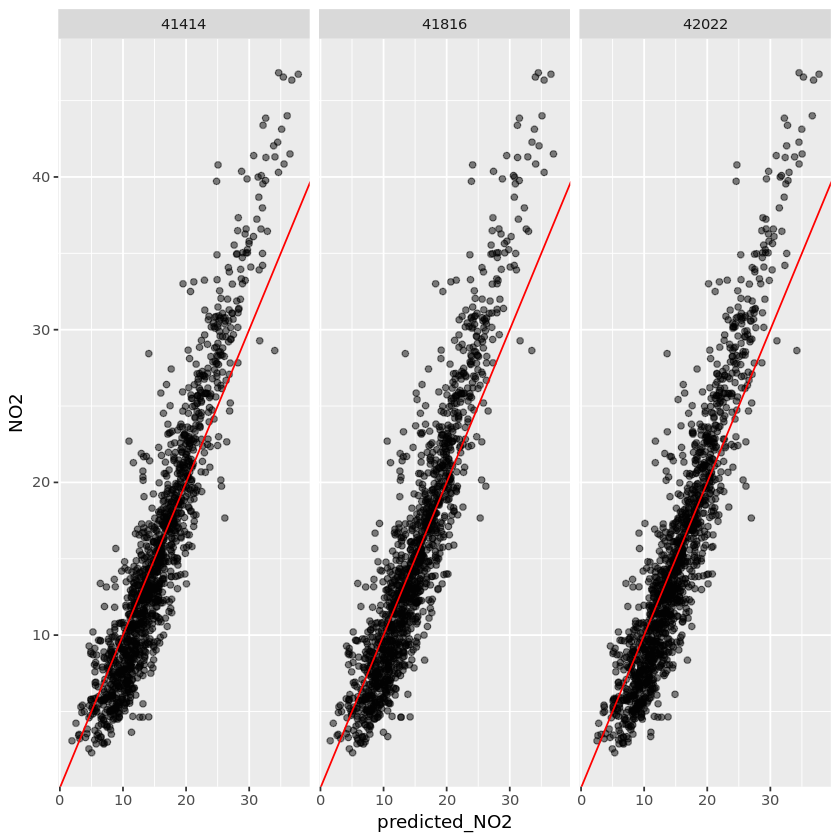

In [93]:
predictions %>% 
    ggplot(aes(x=predicted_NO2, y=NO2)) +
    geom_point(alpha=0.2) +
    geom_abline(slope=1, intercept=0, col="red") +
    facet_wrap(~id)

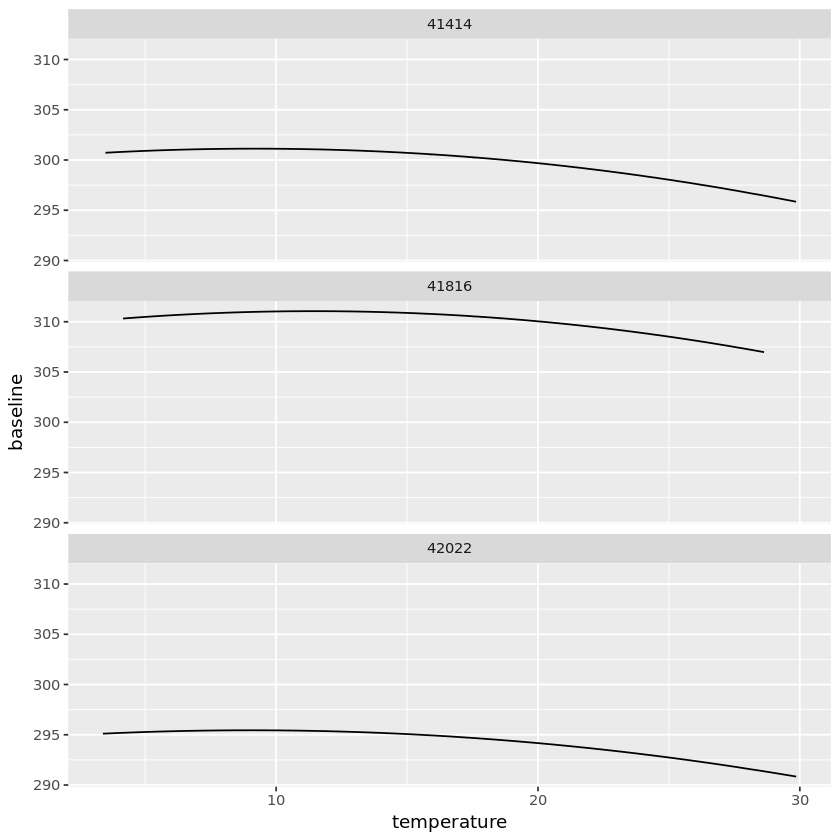

In [79]:
# gas_predictions %>% 
#     ggplot(aes(x=temperature, y=baseline)) +
#     geom_line() +
#     facet_wrap(~id, nrow = 3)

# Deployed model
Deploying the model as as endpoint is suitable for cases where you need to make online inference. Amazon SageMaker lets you deploy your model by providing an endpoint that consumers can invoke by a secure and simple API call using an HTTPS request.

In [82]:
#! takes a few minutes...
# deploy trained model
model_endpoint <- estimator$deploy(initial_instance_count=1L,
                              instance_type='ml.t2.medium')

In [85]:
# Use the test data to generate predictions. Pass comma-separated text to be serialized into JSON format
model_endpoint$serializer <- sagemaker$serializers$CSVSerializer(content_type='text/csv')

In [86]:
# Remove the target column and convert the dataframe to a matrix with no column names:
test_sample <- as.matrix(gas_test[-c(1,2)])
dimnames(test_sample)[[2]] <- NULL

In [87]:
# predict!
predictions_ep <- model_endpoint$predict(test_sample)

In [88]:
json <- reticulate::import("json")

In [89]:
temp <- json$loads(predictions_ep)
temp <- as_tibble(temp)

In [90]:
temp <- sapply(temp, extract_numeric)

extract_numeric() is deprecated: please use readr::parse_number() instead



In [95]:
colnames(temp)

[1] "predictions"

In [ ]:
# predictions_ep1 <- str_split(predictions_ep, pattern = ',', simplify = TRUE)

In [ ]:
# predictions_ep2 <- sapply(X = predictions_ep1, FUN = parse_number)

In [ ]:
# attr(predictions_ep2, "names") <- NULL

In [94]:
# Convert predictions to Integer
gas_predictions_ep <- cbind(temp,
                      gas_test)
# abalone_predictions = as.integer(abalone_predictions)
head(gas_predictions_ep)

New names:
* NA -> ...1



...1,id,NO2,RAW,baseline,temperature
"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19.25913,42022,20.91667,297.1858,294.7527,17.10584
17.44516,42022,19.25000,296.6088,294.8363,16.60335
15.31549,42022,16.95000,295.9173,294.9126,16.11310
15.27740,42022,16.06667,295.9334,294.9767,15.67477
15.58374,42022,16.39167,296.0547,295.0157,15.39307
16.87824,42022,17.25000,296.4984,295.0182,15.37075


In [96]:
colnames(gas_predictions_ep) <- c("predicted_no2", "id", "NO2", "RAW", "baseline", "temperature")

In [98]:
# calculate RMSE
gas_rmse <- gas_predictions %>% 
    group_by(id) %>% 
    summarise(rmse = round(rmse(.), digits=2))
# cat('RMSE for Batch Transform: ', round(gas_rmse, digits=2))
gas_rmse

id,rmse
<dbl>,<dbl>
41414,3.51
41816,3.51
42022,3.51


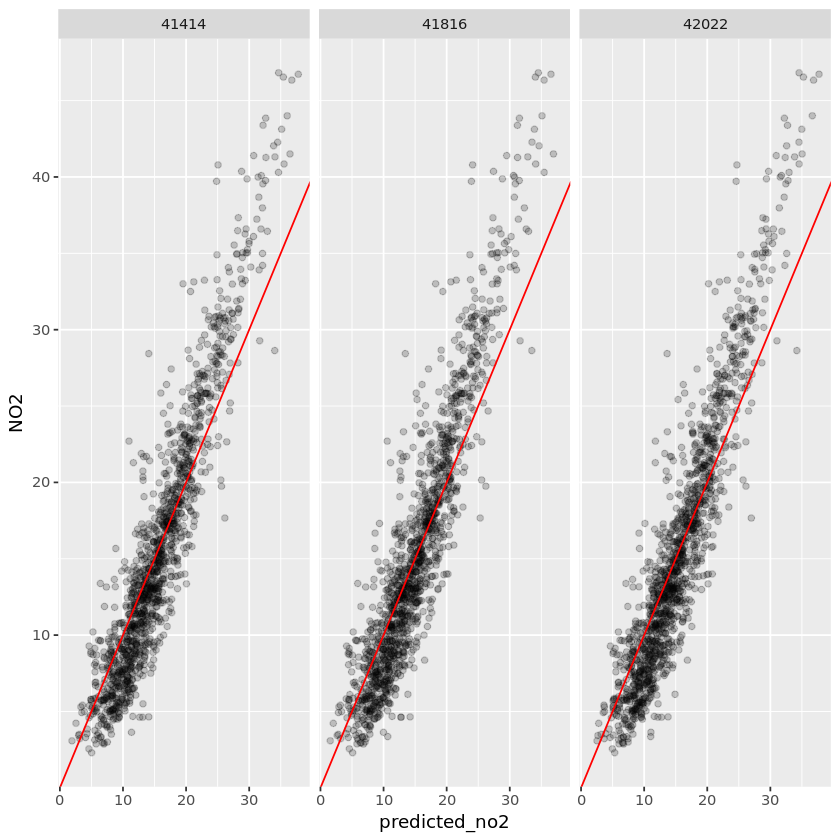

In [99]:
gas_predictions_ep %>% 
    ggplot(aes(x=predicted_no2, y=NO2)) +
    geom_point(alpha=0.2) +
    geom_abline(slope=1, intercept=0, col="red") +
    facet_wrap(~id)

# OPTIONAL

In [100]:
# When you’re done with the model, delete the endpoint to avoid incurring deployment costs:
session$delete_endpoint(model_endpoint$endpoint)